# Setup

Import required libraries including Tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import random
import os
from numpy.random import seed

random.seed(42)
os.environ['PYTHONASHSEED'] = '42' 
seed(42)
tf.random.set_seed(42)

Check for Colab's GPU

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Check connected GPU type

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 12 18:39:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    34W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Mount storage from Google Drive

In [4]:
from google.colab import drive
drive.mount('p2')

Mounted at p2


# Dataset

Load preprocessed dataset

In [5]:
df = pd.read_csv('/content/p2/MyDrive/p2/data/preprocessed_500k_imba.csv', dtype={'text': 'str', 'processed_text': 'str', 'stars': float})
df.fillna('', inplace=True)
df.head()

,text,stars,processed_text
0,Three words: Damn good pastries.\n\nA few mor...,4.0,three word damn good pastry word probably best...
1,Easily one of the worst Red Robin locations. T...,0.0,easily one worst red robin location food delic...
2,Maybe I am just spoiled with good Mexican food...,1.0,maybe spoiled good mexican food growing san di...
3,This Wildflower is always kept clean and the e...,4.0,wildflower always kept clean employee nice pot...
4,Favorite bibimbap in the valley! They also hav...,4.0,favorite bibimbap valley also korean fixing sm...


Inspect distribution of star labels

In [6]:
df['stars'].value_counts()

4.0    197007
3.0    130723
2.0     66808
0.0     59025
1.0     46437
Name: stars, dtype: int64

# Preprocessing

One-hot encoding of star labels

In [7]:
y = tf.keras.utils.to_categorical(df["stars"].values, num_classes=5)
y

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

Split dataset in stratified manner into train, validation and test set with proportion of 6:2:2

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    df['processed_text'], 
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.25, 
    stratify=y_train, 
    random_state=42
)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(300000,)
(100000,)
(100000,)


Check the processed text and class

In [9]:
for i in range(5):
    print(x_train.iloc[i])
    print(y_train[i])
    
for i in range(5):
    print(x_val.iloc[i])
    print(y_val[i])

basically everything menu !had one thing !enjoy crab puppy best twist original hush puppy good vibe way around
[0. 0. 0. 0. 1.]
awesome middle eastern take hot sauce incredible love sandwich rock dish
[0. 0. 0. 0. 1.]
!rude completed order 10 minute lady drive arguing customer store literally yelled another mic !hear proceeded talk bad customer front 8 customer store !be back crew seems toxic wonder would act gm food beverage would expect far concerned update got new staff management gotten much better seems manager working hard customer service night day different glad see people striving better
[0. 0. 0. 1. 0.]
favorite dish tom kha shrimp soup order rice go along soup large enough serving meal pineapple fried rice chock full goody raisin cashew pineapple prefer shrimp meat addition tried chicken satay thai restaurant hand favorite archi would offer curry puff would !need go anywhere else best thai tea lunch special provide enough food although would like able choose soup come soup d

Tokenize the text with max vocabulary of 100,000

In [10]:
MAX_VOCAB_SIZE = 100000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(np.concatenate((x_train, x_val, x_test), axis=0))

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

for i in range(3):
  print(x_train[i])

[759, 75, 21, 532, 9, 60, 237, 346, 2959, 23, 1821, 881, 3296, 2959, 3, 621, 67, 97]
[133, 743, 2130, 83, 108, 38, 691, 31, 81, 853, 44]
[502, 4670, 15, 215, 73, 497, 450, 4805, 120, 474, 585, 3673, 123, 7307, 856, 1935, 764, 99, 120, 325, 602, 120, 474, 196, 11, 2292, 431, 13885, 1421, 7, 1998, 3925, 1, 1249, 7, 374, 257, 2170, 1225, 20, 106, 42, 767, 991, 47, 59, 431, 220, 529, 252, 120, 6, 65, 80, 158, 524, 129, 54, 15787, 59]


Show the top 20 most frequent tokens

In [11]:
i = 0

for word in tokenizer.word_index:
    print(f"{word} : {tokenizer.word_index[word]}")
    i += 1
    if i >= 20:
        break

food : 1
place : 2
good : 3
great : 4
time : 5
service : 6
would : 7
like : 8
one : 9
get : 10
back : 11
go : 12
really : 13
restaurant : 14
order : 15
ordered : 16
u : 17
also : 18
chicken : 19
got : 20


The actual token size in the corpus

In [12]:
vocab_size

143134

Pad the tokens to fixed length of 100

In [13]:
max_length = 100

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=max_length)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen=max_length)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, padding='post', maxlen=max_length)

x_train[:5, :]

array([[  759,    75,    21,   532,     9,    60,   237,   346,  2959,
           23,  1821,   881,  3296,  2959,     3,   621,    67,    97,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  133,   743,  2130,    83,   108,    38,   691,    31,    81,
          853,    44,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

Compare tokens and round-trip text

In [14]:
vocab_list = list(tokenizer.word_index.keys())
token_list = list(tokenizer.word_index.values())

for n in range(3):
    print("Original: ", x_train[n])
    print()
    print("Round-trip: ", " ".join([vocab_list[token_list.index(token)] for token in x_train[n] if token !=0]))
    print()

Original:  [ 759   75   21  532    9   60  237  346 2959   23 1821  881 3296 2959
    3  621   67   97    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

Round-trip:  basically everything menu had one thing enjoy crab puppy best twist original hush puppy good vibe way around

Original:  [ 133  743 2130   83  108   38  691   31   81  853   44    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 

Populate initial word embedding weights based on pre-trained GloVe

In [15]:
embedding_dim = 100

def create_embedding_matrix(filepath, word_index, embedding_dim):
    embedding_matrix = np.zeros((MAX_VOCAB_SIZE, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index and (word_index[word] < MAX_VOCAB_SIZE):
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_matrix = create_embedding_matrix(
    '/content/p2/MyDrive/p2/data/glove.6B.100d.txt',
    tokenizer.word_index,
    embedding_dim
)

print(embedding_matrix.shape)
embedding_matrix[:5]

(100000, 100)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

Calculate the percentage of vocabs found in GloVe and given initial weights

In [16]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / MAX_VOCAB_SIZE

0.56309

# Modeling

Build CNN-LSTM model

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

Show summary of model

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          10000000  
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 100)          30100     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 100)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 50, 100)           80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                        

Compile model with loss function and metrics

In [19]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.00083),
              metrics=metrics)

Train model

In [20]:
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history = model.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 828s 87ms/step - loss: 0.9361 - accuracy: 0.5995 - val_loss: 0.8500 - val_accuracy: 0.6406
Epoch 2/8
9375/9375 [==============================] - 790s 84ms/step - loss: 0.8051 - accuracy: 0.6532 - val_loss: 0.8128 - val_accuracy: 0.6503
Epoch 3/8
9375/9375 [==============================] - 791s 84ms/step - loss: 0.7551 - accuracy: 0.6775 - val_loss: 0.7940 - val_accuracy: 0.6582
Epoch 4/8
9375/9375 [==============================] - 797s 85ms/step - loss: 0.7136 - accuracy: 0.6985 - val_loss: 0.8067 - val_accuracy: 0.6540
Epoch 5/8
9375/9375 [==============================] - 826s 88ms/step - loss: 0.6756 - accuracy: 0.7175 - val_loss: 0.8306 - val_accuracy: 0.6542
Epoch 6/8
9375/9375 [==============================] - 792s 84ms/step - loss: 0.6412 - accuracy: 0.7354 - val_loss: 0.8430 - val_accuracy: 0.6511
Epoch 7/8
9375/9375 [==============================] - 794s 85ms/step - loss: 0.6085 - accuracy: 0.7508 - val_loss: 0.8648 -

Evaluate model with test set

In [21]:
model.load_weights(checkpoint_filepath)

y_pred = model.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 47s 15ms/step
              precision    recall  f1-score   support

           0     0.7075    0.8036    0.7525     11805
           1     0.5200    0.3761    0.4365      9287
           2     0.5176    0.4973    0.5072     13362
           3     0.5554    0.5977    0.5758     26144
           4     0.7858    0.7758    0.7808     39402

    accuracy                         0.6582    100000
   macro avg     0.6173    0.6101    0.6106    100000
weighted avg     0.6558    0.6582    0.6553    100000



array([[ 9486,  1461,   560,   131,   167],
       [ 2749,  3493,  2517,   399,   129],
       [  719,  1587,  6645,  3899,   512],
       [  220,   138,  2633, 15627,  7526],
       [  233,    38,   484,  8079, 30568]])

In [22]:
y_pred = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 47s 15ms/step
              precision    recall  f1-score   support

           0     0.7088    0.8147    0.7580     11805
           1     0.5217    0.3658    0.4300      9287
           2     0.5140    0.4957    0.5047     13362
           3     0.5495    0.5967    0.5721     26145
           4     0.7861    0.7710    0.7785     39401

    accuracy                         0.6562    100000
   macro avg     0.6160    0.6088    0.6087    100000
weighted avg     0.6542    0.6562    0.6532    100000



array([[ 9617,  1371,   556,   123,   138],
       [ 2746,  3397,  2589,   421,   134],
       [  742,  1558,  6624,  3952,   486],
       [  229,   142,  2667, 15600,  7507],
       [  234,    44,   451,  8293, 30379]])

Plot graphs for metrics between validation and train set

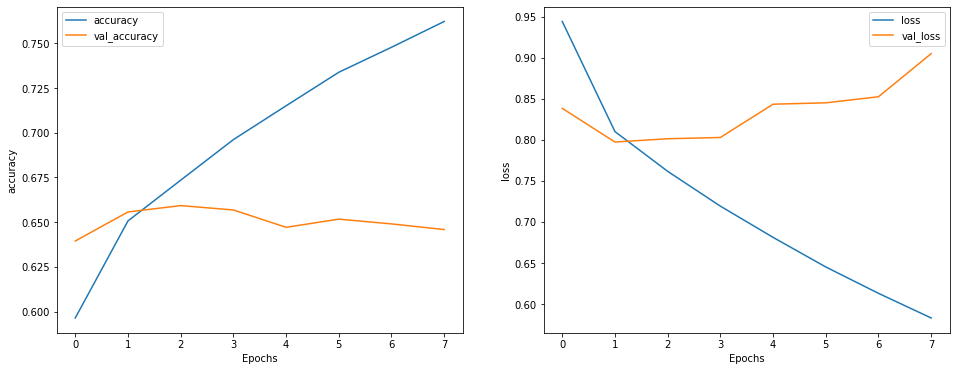

In [ ]:
histories = {
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
}

def plot_graphs(history, metric):
    plt.plot(history[metric])
    plt.plot(history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(histories, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(histories, 'loss')